In [1]:
!pip install -q transformers datasets accelerate scikit-learn torch tqdm indic-transliteration


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

# Install + Imports

In [2]:
import os, torch, pandas as pd
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score


# Configuration

In [3]:

@dataclass
class CFG:
    teacher_model_path: str = "/kaggle/input/finetuned-xlmr"   # your local teacher model
    student_model_name: str = "roberta-base"        # download from Hugging Face
    dataset_dir: str = "/kaggle/input/dataaaaaa"           # folder containing Bangla .txt files
    max_length: int = 128
    train_batch_size: int = 16
    eval_batch_size: int = 32
    num_epochs: int = 10
    lr: float = 5e-5
    alpha: float = 0.3
    temperature: float = 2.0
    use_amp: bool = True
    max_grad_norm: float = 1.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = CFG()
print(cfg)


CFG(teacher_model_path='/kaggle/input/finetuned-xlmr', student_model_name='roberta-base', dataset_dir='/kaggle/input/dataaaaaa', max_length=128, train_batch_size=16, eval_batch_size=32, num_epochs=10, lr=5e-05, alpha=0.3, temperature=2.0, use_amp=True, max_grad_norm=1.0, device='cuda')


# Transliteration Helper

In [4]:
def transliterate_bn_text(text):
    """Convert Bangla text to Latin-script (ITRANS) for RoBERTa input."""
    try:
        return transliterate(text, sanscript.BENGALI, sanscript.ITRANS)
    except Exception:
        return text  # fallback for malformed lines


In [5]:
print(transliterate_bn_text("বাংলাদেশ একটি সুন্দর দেশ।"))
# Example output: baanglaadesha ekiTi sundara desha.


vAMlAdesha ekaTi sundara desha|


# Load Tokenizers

In [6]:
teacher_tokenizer = AutoTokenizer.from_pretrained(cfg.teacher_model_path, use_fast=True)
student_tokenizer = AutoTokenizer.from_pretrained(cfg.student_model_name, use_fast=True)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
pos_path = os.path.join(cfg.dataset_dir, "all_positive_8500.txt")
neg_path = os.path.join(cfg.dataset_dir, "all_negative_3307.txt")

with open(pos_path, "r", encoding="utf-8") as f:
    pos_lines = [transliterate_bn_text(l.strip()) for l in f if l.strip()]

with open(neg_path, "r", encoding="utf-8") as f:
    neg_lines = [transliterate_bn_text(l.strip()) for l in f if l.strip()]

pos_df = pd.DataFrame({"text": pos_lines, "label": 1})
neg_df = pd.DataFrame({"text": neg_lines, "label": 0})
df = pd.concat([pos_df, neg_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Samples={len(df)} | Pos={len(pos_df)} | Neg={len(neg_df)}")
print(df.head())


Samples=11807 | Pos=8500 | Neg=3307
                                                text  label
0  AmAra vAMlAdeshera nATakera bhute dhareChe, oj...      1
1  bhAi, ApanAra hArDa phyAna Ami!vATa eiye ei nA...      0
2  aneka bhAlo ekaTA nATaka ||aneka bhAlovAsi bhA...      1
3                     vAlera nATaka vAlera kanasepTa      0
4  dAruna haYeChe, ei rakama nATaka Aro dekhate chAi      1


# Split & Convert to Dataset

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["label"], random_state=42)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(valid_df),
    "test": Dataset.from_pandas(test_df)
})

def _ensure_labels(example):
    lbl = int(example.get("label", example.get("labels", 0)))
    return {"text": example["text"], "labels": lbl}

for split in dataset.keys():
    dataset[split] = dataset[split].map(
        _ensure_labels,
        remove_columns=[c for c in dataset[split].column_names if c not in ("text", "labels")]
    )

print(dataset)


Map:   0%|          | 0/9445 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 9445
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1181
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1181
    })
})


# Dual Tokenization + DataLoaders

In [9]:
def dual_tokenize_collate(batch):
    texts = [ex["text"] for ex in batch]
    labels = torch.tensor([ex["labels"] for ex in batch], dtype=torch.long)

    t_enc = teacher_tokenizer(texts, truncation=True, max_length=cfg.max_length, padding=True, return_tensors="pt")
    s_enc = student_tokenizer(texts, truncation=True, max_length=cfg.max_length, padding=True, return_tensors="pt")

    return {"teacher_inputs": t_enc, "student_inputs": s_enc, "labels": labels}

train_loader = DataLoader(dataset["train"], batch_size=cfg.train_batch_size, shuffle=True, collate_fn=dual_tokenize_collate)
val_loader   = DataLoader(dataset["validation"], batch_size=cfg.eval_batch_size, shuffle=False, collate_fn=dual_tokenize_collate)
test_loader  = DataLoader(dataset["test"], batch_size=cfg.eval_batch_size, shuffle=False, collate_fn=dual_tokenize_collate)


# Load Models

In [10]:
teacher = AutoModelForSequenceClassification.from_pretrained(cfg.teacher_model_path).to(cfg.device)
student = AutoModelForSequenceClassification.from_pretrained(cfg.student_model_name, num_labels=2).to(cfg.device)
teacher.eval()
print("✅ Models loaded.")


2025-10-25 20:37:10.837408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761424631.084842      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761424631.151665      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Models loaded.


# Loss + Optimizer + Scheduler

In [11]:
def kd_loss_fn(student_logits, teacher_logits, T):
    p_teacher = torch.nn.functional.softmax(teacher_logits / T, dim=-1)
    log_p_student = torch.nn.functional.log_softmax(student_logits / T, dim=-1)
    return nn.KLDivLoss(reduction="batchmean")(log_p_student, p_teacher) * (T * T)

ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(student.parameters(), lr=cfg.lr)
num_training_steps = len(train_loader) * cfg.num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 0, num_training_steps)
scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp)


/tmp/ipykernel_37/3071039633.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp)


# Evaluation Function

In [12]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    preds, labels_all = [], []
    total_loss = 0.0
    for batch in loader:
        inputs = {k: v.to(cfg.device) for k, v in batch["student_inputs"].items()}
        labels = batch["labels"].to(cfg.device)
        outputs = model(**inputs)
        loss = ce_loss(outputs.logits, labels)
        total_loss += loss.item() * labels.size(0)
        preds += outputs.logits.argmax(-1).cpu().tolist()
        labels_all += labels.cpu().tolist()
    acc = accuracy_score(labels_all, preds)
    f1 = f1_score(labels_all, preds)
    return {"loss": total_loss/len(loader.dataset), "acc": acc, "f1": f1}


# Training Loop with KD

In [13]:
best_f1, best_state = -1, None

for epoch in range(1, cfg.num_epochs + 1):
    student.train()
    running_loss, seen = 0.0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        labels = batch["labels"].to(cfg.device)
        t_in = {k: v.to(cfg.device) for k, v in batch["teacher_inputs"].items()}
        s_in = {k: v.to(cfg.device) for k, v in batch["student_inputs"].items()}

        with torch.no_grad():
            t_logits = teacher(**t_in).logits

        with torch.amp.autocast("cuda", enabled=cfg.use_amp):
            s_logits = student(**s_in).logits
            loss_kd = kd_loss_fn(s_logits, t_logits, cfg.temperature)
            loss_ce = ce_loss(s_logits, labels)
            loss = cfg.alpha * loss_kd + (1 - cfg.alpha) * loss_ce

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student.parameters(), cfg.max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        running_loss += loss.item() * labels.size(0)
        seen += labels.size(0)

    val_metrics = evaluate(student, val_loader)
    print(f"Epoch {epoch}: TrainLoss={running_loss/seen:.4f} | ValAcc={val_metrics['acc']:.4f} | ValF1={val_metrics['f1']:.4f}")

    if val_metrics["f1"] > best_f1:
        best_f1, best_state = val_metrics["f1"], {k: v.cpu().clone() for k, v in student.state_dict().items()}
        print("✅ Best model updated!")

if best_state:
    student.load_state_dict(best_state)
    student.save_pretrained("./distilled-student-translit")
    print("💾 Saved best transliterated student → ./distilled-student-translit")


Epoch 1: 100%|██████████| 591/591 [02:13<00:00,  4.43it/s]


Epoch 1: TrainLoss=0.4691 | ValAcc=0.8357 | ValF1=0.8974
✅ Best model updated!


Epoch 2: 100%|██████████| 591/591 [02:17<00:00,  4.30it/s]


Epoch 2: TrainLoss=0.3839 | ValAcc=0.8781 | ValF1=0.9212
✅ Best model updated!


Epoch 3: 100%|██████████| 591/591 [02:16<00:00,  4.34it/s]


Epoch 3: TrainLoss=0.3586 | ValAcc=0.9356 | ValF1=0.9560
✅ Best model updated!


Epoch 4: 100%|██████████| 591/591 [02:17<00:00,  4.31it/s]


Epoch 4: TrainLoss=0.3391 | ValAcc=0.9323 | ValF1=0.9544


Epoch 5: 100%|██████████| 591/591 [02:16<00:00,  4.32it/s]


Epoch 5: TrainLoss=0.3209 | ValAcc=0.9441 | ValF1=0.9617
✅ Best model updated!


Epoch 6: 100%|██████████| 591/591 [02:17<00:00,  4.31it/s]


Epoch 6: TrainLoss=0.3158 | ValAcc=0.9340 | ValF1=0.9552


Epoch 7: 100%|██████████| 591/591 [02:17<00:00,  4.30it/s]


Epoch 7: TrainLoss=0.3014 | ValAcc=0.9348 | ValF1=0.9557


Epoch 8: 100%|██████████| 591/591 [02:17<00:00,  4.31it/s]


Epoch 8: TrainLoss=0.2944 | ValAcc=0.9424 | ValF1=0.9606


Epoch 9: 100%|██████████| 591/591 [02:17<00:00,  4.29it/s]


Epoch 9: TrainLoss=0.2892 | ValAcc=0.9407 | ValF1=0.9593


Epoch 10: 100%|██████████| 591/591 [02:16<00:00,  4.31it/s]


Epoch 10: TrainLoss=0.2842 | ValAcc=0.9416 | ValF1=0.9598
💾 Saved best transliterated student → ./distilled-student-translit


# Final Test Evaluation

In [14]:
test_metrics = evaluate(student, test_loader)
print(f"🧠 Test Results | Loss={test_metrics['loss']:.4f} | Acc={test_metrics['acc']:.4f} | F1={test_metrics['f1']:.4f}")


🧠 Test Results | Loss=0.2708 | Acc=0.9441 | F1=0.9615


# Logit Alignment Evaluation

In [15]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
from tqdm import tqdm

@torch.no_grad()
def evaluate_alignment(teacher, student, loader):
    teacher.eval()
    student.eval()

    similarities, correlations = [], []
    teacher_preds, student_preds, labels_all = [], [], []

    for batch in tqdm(loader, desc="🔍 Evaluating alignment"):
        t_in = {k: v.to(cfg.device) for k, v in batch["teacher_inputs"].items()}
        s_in = {k: v.to(cfg.device) for k, v in batch["student_inputs"].items()}
        labels = batch["labels"].cpu().tolist()

        t_logits = teacher(**t_in).logits.cpu().numpy()
        s_logits = student(**s_in).logits.cpu().numpy()

        # Softmax probabilities
        t_probs = torch.softmax(torch.tensor(t_logits), dim=-1).numpy()
        s_probs = torch.softmax(torch.tensor(s_logits), dim=-1).numpy()

        # Cosine similarity between logits
        for i in range(len(t_logits)):
            sim = 1 - cosine(t_logits[i], s_logits[i])
            corr, _ = pearsonr(t_probs[i], s_probs[i])
            similarities.append(sim)
            correlations.append(corr)
            teacher_preds.append(np.argmax(t_probs[i]))
            student_preds.append(np.argmax(s_probs[i]))
            labels_all.append(labels[i])

    acc_align = np.mean(np.array(teacher_preds) == np.array(student_preds))
    avg_sim = np.mean(similarities)
    avg_corr = np.mean(correlations)
    return {
        "logit_cosine": avg_sim,
        "prob_corr": avg_corr,
        "pred_alignment": acc_align
    }


In [16]:
alignment = evaluate_alignment(teacher, student, val_loader)
print(f"""
🧩 Alignment Results:
  🔹 Logit Cosine Similarity : {alignment['logit_cosine']:.4f}
  🔹 Probability Correlation : {alignment['prob_corr']:.4f}
  🔹 Prediction Agreement    : {alignment['pred_alignment']:.4f}
""")


🔍 Evaluating alignment: 100%|██████████| 37/37 [00:15<00:00,  2.31it/s]


🧩 Alignment Results:
  🔹 Logit Cosine Similarity : 0.5049
  🔹 Probability Correlation : 0.4767
  🔹 Prediction Agreement    : 0.7384



In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

def transliterate_bn_text(text):
    return transliterate(text, sanscript.BENGALI, sanscript.ITRANS)

student_path = "./distilled-student-translit"
student = AutoModelForSequenceClassification.from_pretrained(student_path).to("cuda")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def predict_sentiment(text):
    text_trans = transliterate_bn_text(text)
    inputs = tokenizer(text_trans, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        logits = student(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    label = "Positive" if probs[1] > probs[0] else "Negative"
    return label, probs

sample = "আমি বাংলা বই পড়ি না "
label, probs = predict_sentiment(sample)
print(f"Transliterated: {transliterate_bn_text(sample)}")
print(f"Prediction: {label} | Probabilities: {probs}")


Transliterated: Ami vAMlA vai pa.Di nA 
Prediction: Negative | Probabilities: [0.54697275 0.45302722]


# t-SNE Visualization Cell

Visualizing 300 samples
Extracting teacher embeddings ...
Extracting student embeddings ...
Running t-SNE (≈1–2 min) ...


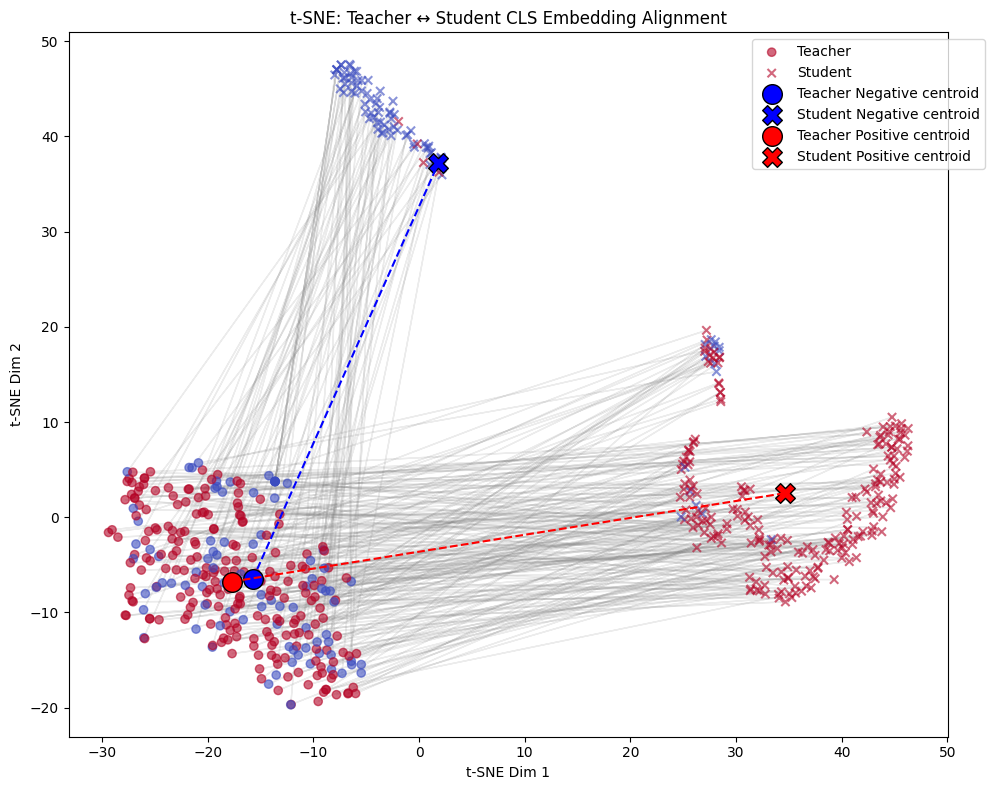

In [22]:
# ==============================================================
# 🧠 Enhanced t-SNE Visualization: Teacher ↔ Student Alignment
# ==============================================================

import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

teacher.eval()
student.eval()

# --- Sample subset from validation dataset ---
num_samples = 300  # reduce to 300 for readability
subset = random.sample(list(dataset["validation"]), k=min(num_samples, len(dataset["validation"])))
texts = [ex["text"] for ex in subset]
labels = np.array([ex["labels"] for ex in subset])
print(f"Visualizing {len(texts)} samples")

# --- Helper to extract CLS embeddings ---
def extract_cls_embeddings(model, tokenizer, texts, max_len=cfg.max_length):
    embs = []
    for i in range(0, len(texts), cfg.eval_batch_size):
        batch = texts[i : i + cfg.eval_batch_size]
        enc = tokenizer(
            batch,
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors="pt"
        ).to(cfg.device)
        with torch.no_grad():
            out = model(**enc, output_hidden_states=True)
            cls = out.hidden_states[-1][:, 0, :].detach().cpu().numpy()
        embs.append(cls)
    return np.concatenate(embs, axis=0)

print("Extracting teacher embeddings ...")
teacher_embs = extract_cls_embeddings(teacher, teacher_tokenizer, texts)
print("Extracting student embeddings ...")
student_embs = extract_cls_embeddings(student, student_tokenizer, texts)

# --- Run t-SNE on concatenated features ---
print("Running t-SNE (≈1–2 min) ...")
all_embs = np.concatenate([teacher_embs, student_embs], axis=0)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=2000)
all_2d = tsne.fit_transform(all_embs)

n = len(texts)
teacher_2d, student_2d = all_2d[:n], all_2d[n:]

# --- Compute centroids for each class ---
centroids = {}
for label in np.unique(labels):
    centroids[(label, "teacher")] = teacher_2d[labels == label].mean(axis=0)
    centroids[(label, "student")] = student_2d[labels == label].mean(axis=0)

# --- Plot ---
plt.figure(figsize=(10,8))

# Arrows teacher→student
for i in range(n):
    plt.arrow(
        teacher_2d[i,0], teacher_2d[i,1],
        student_2d[i,0] - teacher_2d[i,0],
        student_2d[i,1] - teacher_2d[i,1],
        color="gray", alpha=0.15, head_width=0.0, length_includes_head=True
    )

# Teacher points
plt.scatter(teacher_2d[:,0], teacher_2d[:,1],
            c=labels, cmap="coolwarm", marker="o", alpha=0.6, label="Teacher")
# Student points
plt.scatter(student_2d[:,0], student_2d[:,1],
            c=labels, cmap="coolwarm", marker="x", alpha=0.6, label="Student")

# Centroids
for label, color, name in [(0, "blue", "Negative"), (1, "red", "Positive")]:
    t_c = centroids[(label, "teacher")]
    s_c = centroids[(label, "student")]
    plt.scatter(*t_c, color=color, edgecolor="k", s=200, marker="o", label=f"Teacher {name} centroid")
    plt.scatter(*s_c, color=color, edgecolor="k", s=200, marker="X", label=f"Student {name} centroid")
    plt.plot([t_c[0], s_c[0]], [t_c[1], s_c[1]], color=color, linestyle="--", linewidth=1.5)

plt.title("t-SNE: Teacher ↔ Student CLS Embedding Alignment")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.show()


# Centroid & Cluster Similarity Analysis

In [23]:
# ==============================================================
# 📊 Centroid and Cluster Similarity Analysis
# ==============================================================

from scipy.spatial.distance import cosine, euclidean

# Compute centroids again (if not already defined)
centroids = {}
for label in np.unique(labels):
    centroids[(label, "teacher")] = teacher_2d[labels == label].mean(axis=0)
    centroids[(label, "student")] = student_2d[labels == label].mean(axis=0)

# Helper to compute dispersion (cluster spread)
def cluster_dispersion(points, centroid):
    return np.mean([euclidean(p, centroid) for p in points])

results = []

for label, name in [(0, "Negative"), (1, "Positive")]:
    t_c = centroids[(label, "teacher")]
    s_c = centroids[(label, "student")]
    
    cos_sim = 1 - cosine(t_c, s_c)
    euc_dist = euclidean(t_c, s_c)
    
    t_disp = cluster_dispersion(teacher_2d[labels == label], t_c)
    s_disp = cluster_dispersion(student_2d[labels == label], s_c)
    
    results.append({
        "Label": name,
        "Centroid Cosine Sim": cos_sim,
        "Centroid Distance": euc_dist,
        "Teacher Spread": t_disp,
        "Student Spread": s_disp
    })

pd.DataFrame(results)


,Label,Centroid Cosine Sim,Centroid Distance,Teacher Spread,Student Spread
0,Negative,-0.426924,47.067696,8.518804,12.970150
1,Positive,-0.957746,53.217567,8.113226,10.265473
